In [1]:
import os
import sys

import branca.colormap as cm
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

sys.path.insert(0, "../src")
import json
import time as ti
import math

import geopandas as gpd
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm
import seaborn as sns 
from IPython.display import display, Math, Latex
import requests

from BrusselsMap import BrusselsMap
from GeoJsonHandler import GeoJsonHandler

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
import urllib.request

In [3]:
%load_ext autoreload
%autoreload 2

# First, let's plot the demand cluster centers

In [4]:
# Load geodata
r_path = r"../data/final_data/sector.json"
path = os.path.join(os.getcwd(), r_path)
sectors = GeoJsonHandler(path, "NAME_FRE")

In [5]:
mymap = BrusselsMap(sectors)

dff = sectors.gdf[["NAME_FRE", "CENTER_LONG", "CENTER_LAT"]]
mymap.add_markers(data=dff, icon="bolt")
mymap.map

# Now let's try to compute the distance OD Matrix between these points

First, let's define the function need to perform the HTTP GET request. All the assumptions regarding this matrix are under this first link below.

- Resources: https://docs.microsoft.com/en-us/bingmaps/rest-services/examples/distance-matrix-asynchronous-example

- Example: https://docs.microsoft.com/en-us/bingmaps/rest-services/examples/distance-matrix-example

The HTTP GET request works as follow:

https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins={lat0,long0;lat1,lon1;latM,lonM}&destinations={lat0,lon0;lat1,lon1;latN,longN}&travelMode={travelMode}&startTime={startTime}&timeUnit={timeUnit}&key={BingMapsKey}

- origins: list of lat, long coordinates of origins
- destionations: list of lat, long coordinates of destinations
- travelMode: `Driving`
- startTime: `2021-11-15-07:00`
- timeUnit
- BingMapsKey

In [6]:
def get_data(orig, dest, size_x, size_y):
    # Your Bing Maps Key
    bingMapsKey = "Ah52Budr_8V_sE1HKdPH-INIK_RDqas1zgkSJwdtB3GW3Dm04DsNm3lzkoXmpPc9"

    # input information
    travelMode = "Driving"
    startTime = "2021-11-15-07:00"
    distanceUnit = "km"
    timeUnit = "minute"

    routeUrl = (
        "https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?"
        + f"origins={orig}"
        + f"&destinations={dest}"
        + f"&travelMode={travelMode}"
        + f"&startTime={startTime}"
        + f"&timeUnit={timeUnit}"
        + f"&key={bingMapsKey}"
    )

    # request = urllib.request.Request(routeUrl)
    # response = urllib.request.urlopen(request, proxies={"http":"http://myproxy:3129"})
    # data = json.load(response)

    response = requests.get(routeUrl)
    data = response.json()

    distance, time = build_od_matrix(data, (size_x, size_y))
    return distance, time

In [7]:
def build_od_matrix(data, size):

    resources = data["resourceSets"][0]["resources"][0]["results"]

    distance = np.zeros((size[0], size[1]))
    time = np.zeros((size[0], size[1]))

    for i in range(size[0]):
        for j in range(size[1]):
            distance[i, j] = resources[i * size[1] + j]["travelDistance"]
            time[i, j] = resources[i * size[1] + j]["travelDuration"]

    return distance, time

## Prepare the origin-destination data using the centers of each demand clusters

Due to the request size constraints, we cannot query more than 2500 OD-pairs in each HTTP GET request. Therefore, I divided the matrix to populate in 36 sub-matrices that are populated through an HTTP GET request to BingMaps Services.

In [8]:
dff = sectors.gdf[["NAME_FRE", "CENTER_LONG", "CENTER_LAT"]]
dff.head()

,NAME_FRE,CENTER_LONG,CENTER_LAT
0,CONSCIENCE,4.401070,50.871295
1,HELMET,4.387886,50.874418
2,VIEUX LAEKEN OUEST,4.342702,50.876682
3,VIEUX LAEKEN EST,4.352387,50.875449
4,INDUSTRIE NORD,4.396198,50.894203


In [9]:
# Matrix Initialization
distance_matrix = np.zeros((145, 145))
time_matrix = np.zeros((145, 145))

In [10]:
# Compute the list of origin-destinations points
long = list(dff["CENTER_LONG"])
lat = list(dff["CENTER_LAT"])

points = []
for i, j in zip(lat, long):
    points.append(str(i) + "," + str(j))

In [11]:
points[0:3]

['50.87129527725803,4.401070086950802',
 '50.87441753720841,4.387885864290625',
 '50.87668199576042,4.342702081762683']

In [12]:
N = 25
Nn = math.ceil(145/N)

querry=False

if querry:

    ## Querying BingMaps Services
    for i in tqdm(range(Nn)):  # division in 6 batches
        min_, max_ = int(i * N), int(min(145, (i + 1) * N))
        origins = ";".join(points[min_:max_])

        for j in range(Nn):
            # ti.sleep(5)

            min_j, max_j = int(j * N), int(m../data/ (j + 1) * N))
            destinations = ";".join(points[min_j:max_j])

            distance, time = get_data(
                origins, destinations, size_x=int(max_ - min_), size_y=int(max_j - min_j)
            )

            # print(min_, max_, min_j, max_j)

            distance_matrix[min_:max_, min_j:max_j] = distance
            time_matrix[min_:max_, min_j:max_j] = time

    np.savetxt("../data/bing_maps/BingMapsAPI_Test3.txt", distance_matrix, fmt="%1.3f")

 ... (more hidden) ...


KeyboardInterrupt: 

In [ ]:
# np.savetxt('../data/bing_maps/BingMapsAPI_Test2.txt', distance_matrix, fmt='%1.3f')

#### Convert results into two DataFrame (Distance/Time) and save into CSV.

In [ ]:
if querry:
    dists = pd.DataFrame(distance_matrix, columns=sectors.names)
    dists["origin"] = sectors.names
    dists.set_index("origin", inplace=True)

    times = pd.DataFrame(time_matrix, columns=sectors.names)
    times["origin"] = sectors.names
    times.set_index("origin", inplace=True)
    
    #Save data
    dists.to_csv("../data/final_data/DemandClusters-ODMatrix-Km.csv")
    times.to_csv("../data/final_data/DemandClusters-ODMatrix-Minutes.csv")

# Now, let's build the unprocessed demand OD Matrix for the city of Brussels

In [6]:
dists = pd.read_csv("../data/final_data/DemandClusters-ODMatrix-Km.csv").set_index(
    "origin"
)
dists.tail()

,CONSCIENCE,HELMET,VIEUX LAEKEN OUEST,VIEUX LAEKEN EST,INDUSTRIE NORD,INDUSTRIE OTAN,PAIX,GARE DE SCHAERBEEK,DOMAINE ROYAL LAEKEN,HOUBA,HAREN,HEEMBEEK,MUTSAARD,POTAARDE,BERCHEM SAINTE-AGATHE CENTRE,SCHEUTBOS,KORENBEEK,BOIS DU LAARBEEK - POELBOS,VILLAS DE GANSHOREN,GANSHOREN CENTRE,HEYMBOSCH - AZ-JETTE,HOPITAL FRANCAIS,KARREVELD,HEYSEL,PARC ELISABETH,BASILIQUE,JETTE CENTRE,PARC BAUDOUIN - DIELEGEMBOS,GARE DE L'OUEST,KOEKELBERG,WOESTE,MOLENBEEK HISTORIQUE,VAL D'OR,DAILLY,REYERS,BEGUINAGE - DIXMUDE,PADUWA,CHAUSSEE DE HAECHT,BOTANIQUE,QUARTIER NORD,QUARTIER BRABANT,JOSAPHAT,GARE JOSAPHAT,PARC JOSAPHAT,QUARTIER MARITIME,AVENUE LEOPOLD III,TERDELT,COLLIGNON,CIMETIERE DE BRUXELLES,HAUT SAINT-GILLES,CHATELAIN,CHASSE,LOUISE - LONGUE HAIE,BOSNIE,BERCKMANS - HOTEL DES MONNAIES,FLAGEY - MALIBRAN,PORTE DE HAL,SAINT-PIERRE,GARE DU MIDI,JOURDAN,CUREGHEM VETERINAIRE,MATONGE,MAROLLES,CUREGHEM BARA,SABLON,PARC LEOPOLD,QUARTIER EUROPEEN,CINQUANTENAIRE,STALINGRAD,INDUSTRIE BIRMINGHAM,CUREGHEM ROSEE,ANNEESSENS,QUARTIER ROYAL,GRAND PLACE,SQUARES,DANSAERT,DUCHESSE,SAINT-JOSSE CENTRE,NOTRE-DAME AUX NEIGES,MARTYRS,NEERPEDE,VOGELENZANG - ERASME,BON AIR,MOORTEBEEK - PETERBOS,SCHERDEMAEL,PARC DES ETANGS,BIZET - ROUE - CERIA,MACHTENS,VEEWEYDE - AURORE,PARC ASTRID,ANDERLECHT CENTRE - WAYEZ,BUFFON,INDUSTRIE SUD,SCHEUT,PARC FORESTIER,SAINT-DENIS - NEERSTALLE,PARC MARIE-JOSE,VIVIER D'OIE,KRIEKENPUT - HOMBORCH - VERREWINKEL,KALEVOET - MOENSBERG,CIMETIERE SAINT-GILLES,SAINT-JOB KAUWBERG,FORT JACO,DIEWEG,GLOBE,OBSERVATOIRE,PARC WOLVENDAEL,VOSSEGAT - ROOSENDAAL,BOIS DE LA CAMBRE,BOONDAEL,MONTJOIE - LANGEVELD,CHURCHILL,VAN VOLXEM - VAN HAELEN,MOLIERE - LONGCHAMP,ALTITUDE 100,UNIVERSITE,PARC DUDEN - PARC DE FOREST,ETANGS D'IXELLES,CIMETIERE D'IXELLES,BRUGMANN - LEPOUTRE,BAS FOREST,HOPITAL ETTERBEEK - IXELLES,FORET DE SOIGNES,PORTE TERVUEREN,DRIES,PLASKY,DELTA,CHAUSSEE DE WAVRE - SAINT-JULIEN,WATERMAEL CENTRE,SAINT-MICHEL,GEORGES HENRI,CHANT D'OISEAU,GRIBAUMONT,BOITSFORT CENTRE,TROIS TILLEULS,ROODEBEEK - CONSTELLATIONS,AUDERGHEM CENTRE,PARC DE LA WOLUWE,BOULEVARD DE LA WOLUWE,TRANSVAAL,PUTDAAL,KAPELLEVELD,SAINT-PAUL,STOCKEL,SAINTE-ALIX - JOLI BOIS
origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PUTDAAL,7.764,8.386,13.085,11.226,20.360,15.382,16.812,8.606,24.877,13.957,14.816,19.742,25.257,30.899,13.106,13.749,13.095,13.362,12.862,12.380,25.027,12.033,11.200,24.363,11.173,11.360,12.812,13.787,11.130,10.229,11.309,11.015,6.125,6.823,5.908,8.788,13.163,8.171,8.356,9.220,9.038,6.609,6.300,7.672,10.273,7.506,7.544,8.512,14.265,9.733,9.586,5.112,8.271,9.890,8.974,8.000,9.910,4.925,10.098,5.608,11.005,8.076,9.032,10.612,8.573,7.900,6.179,5.105,10.098,11.965,10.971,10.350,7.118,7.940,7.127,8.678,11.566,7.743,7.379,8.355,34.481,36.182,32.556,14.802,34.198,14.451,13.803,13.081,13.358,15.562,13.044,15.056,12.678,12.672,12.713,13.896,12.220,16.207,12.066,12.111,12.614,10.005,8.375,10.419,10.504,9.190,10.378,10.425,7.663,5.415,8.263,7.753,12.126,10.883,10.981,5.222,10.692,6.569,5.519,10.773,11.157,5.512,5.450,4.817,5.733,5.595,5.222,2.861,4.907,4.445,4.751,3.478,2.981,4.105,3.329,5.495,1.462,1.712,3.157,3.015,0.000,5.049,1.728,3.246,2.213
KAPELLEVELD,12.520,13.287,22.694,22.321,16.015,11.037,12.467,13.585,20.532,20.819,10.471,15.397,20.912,26.554,24.772,27.583,13.386,25.945,13.153,12.671,20.682,12.324,11.491,20.018,11.464,11.651,21.802,21.393,11.421,10.520,11.600,11.306,2.333,11.802,4.845,9.079,3.681,8.462,8.647,9.511,9.329,11.588,11.279,12.651,10.564,5.054,12.523,13.491,4.783,10.024,9.877,6.471,8.562,10.181,9.265,8.011,10.201,5.216,10.389,5.899,11.296,8.367,9.323,10.903,8.864,8.191,6.470,5.396,10.389,12.256,11.262,10.641,7.409,8.231,7.418,8.969,11.857,8.034,7.670,8.646,30.136,31.837,28.211,27.855,29.853,30.112,31.611,13.372,13.649,29.075,29.684,29.220,12.969,29.074,13.004,14.187,12.511,18.712,21.264,13.707,14.210,11.826,18.900,11.967,11.863,10.507,11.467,11.784,9.022,8.164,9.

In [7]:
# dists[['ALTITUDE 100', 'BOONDAEL',"VIVIER D'OIE","UNIVERSITE", "STOCKEL"]]

In [8]:
prox = pd.read_csv("../data/proximus/proximusFrequentTrip_RandomlyGenerated.csv").drop(
    columns=["Unnamed: 0"]
)
prox.head()

,originNB,destinationNB,regularTripSample,irregularTripSample
0,ALTITUDE 100,ALTITUDE 100,242,4066
1,ALTITUDE 100,ANDERLECHT CENTRE - WAYEZ,9666,7490
2,ALTITUDE 100,ANNEESSENS,556,8981
3,ALTITUDE 100,AUDERGHEM CENTRE,9465,7964
4,ALTITUDE 100,AVENUE LEOPOLD III,7479,318


In [9]:
dists_long = (
    dists.unstack()
    .reset_index()
    .rename(
        columns={"level_0": "destinationNB", "origin": "originNB", 0: "travelDistance"}
    )[["originNB", "destinationNB", "travelDistance"]]
)

prox = pd.merge(prox, dists_long, on=["originNB","destinationNB"], how="outer").fillna(0)
prox

,originNB,destinationNB,regularTripSample,irregularTripSample,travelDistance
0,ALTITUDE 100,ALTITUDE 100,242.0,4066.0,0.000
1,ALTITUDE 100,ANDERLECHT CENTRE - WAYEZ,9666.0,7490.0,5.309
2,ALTITUDE 100,ANNEESSENS,556.0,8981.0,4.277
3,ALTITUDE 100,AUDERGHEM CENTRE,9465.0,7964.0,10.054
4,ALTITUDE 100,AVENUE LEOPOLD III,7479.0,318.0,11.750
...,...,...,...,...,...
21020,PARC DES ETANGS,SAINTE-ALIX - JOLI BOIS,0.0,0.0,33.978
21021,PARC ASTRID,SAINTE-ALIX - JOLI BOIS,0.0,0.0,31.335
21022,PARC FORESTIER,SAINTE-ALIX - JOLI BOIS,0.0,0.0,31.405
21023,PARC MARIE-JOSE,SAINTE-ALIX - JOLI BOIS,0.0,0.0,20.232


### <font color='red'>Trips inside one neighborhood: </font> 

It doesn't make sense to consider that trips inside a neighborhood have a travelDistance of 0 kilometers. Therefore, we need to make an assumption.

We can remove:
- We remove all elements for which we don't have a significant population desnity (ex. parcs, forests). (Statistical test?)
    - Selected threshold: 200habitants / Square meter --> Average for Brussels in 7500habitants/M^2
    - Example: `Foret de Soignes` as it has a huge area and no population density.
    


In [10]:
areas = sectors.gdf[['NAME_FRE','AREA', 'DENS']].sort_values(by='AREA')
areas = areas[areas['DENS'] > 200]
areas.tail()

KeyError: "['DENS'] not in index"

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.scatterplot(x="NAME_FRE", y="AREA", data=areas, palette="Blues_d")
ax.set(xlabel=None) ;
ax.set(xticklabels=[]) ; 

NameError: name 'areas' is not defined

In [12]:
import matplotlib.pyplot as plt
ax = sns.histplot(x="AREA", data=areas[areas["AREA"]<4], palette="Blues_d", bins=25)
plt.savefig('C:/Users/vic_t/OneDrive/MFE/Notes/src/areas-histogram.png')

NameError: name 'areas' is not defined

1. Suppose each neighborhood is a quare.
2. $c = \sqrt{AREA}$
3. $d = \frac{c}{2}$

We assume that the average trip inside a neighborhood in half the length of a square. The majority of neighborhoods are under $2km^2$, meaning that the average intra-neighborhood distance we would use is: $\frac{\sqrt{a}}{2} = 700m $ Can we assume that people take their car for 700 meters? 

As this distance is extremely small, we will make the assumption that it is roughly people walking.

## Assumption of IEA - Average EV consumption:
    
Passenger car: consumption (on road) 0.2-0.24 kWh/km

An assumption has to be done 

(source: Document B15 - PAGE 51 - Figure Legend -  Link here: https://iea.blob.core.windows.net/assets/7d7e049e-ce64-4c3f-8f23-6e2f529f31a8/Global_EV_Outlook_2019.pdf)

In [36]:
prox['regularDemand'] = prox['regularTripSample'] * prox['travelDistance']
prox['irregularDemand'] = prox['irregularTripSample'] * prox['travelDistance']
prox['totalDemand'] = prox['regularDemand'] + prox['irregularDemand']

prox['regularEnergyDemand'] = prox['regularDemand'] * 0.22 
prox['irregularEnergyDemand'] = prox['irregularDemand'] * 0.22 

In [37]:
prox.head(10)

,originNB,destinationNB,regularTripSample,irregularTripSample,travelDistance,regularDemand,irregularDemand,totalDemand,regularEnergyDemand,irregularEnergyDemand
0,ALTITUDE 100,ALTITUDE 100,242.0,4066.0,0.000,0.000,0.000,0.000,0.00000,0.00000
1,ALTITUDE 100,ANDERLECHT CENTRE - WAYEZ,9666.0,7490.0,5.309,51316.794,39764.410,91081.204,11289.69468,8748.17020
2,ALTITUDE 100,ANNEESSENS,556.0,8981.0,4.277,2378.012,38411.737,40789.749,523.16264,8450.58214
3,ALTITUDE 100,AUDERGHEM CENTRE,9465.0,7964.0,10.054,95161.110,80070.056,175231.166,20935.44420,17615.41232
4,ALTITUDE 100,AVENUE LEOPOLD III,7479.0,318.0,11.750,87878.250,3736.500,91614.750,19333.21500,822.03000
5,ALTITUDE 100,BAS FOREST,4446.0,2323.0,2.282,10145.772,5301.086,15446.858,2232.06984,1166.23892
6,ALTITUDE 100,BASILIQUE,8137.0,3127.0,9.865,80271.505,30847.855,111119.360,17659.73110,6786.52810
7,ALTITUDE 100,BEGUINAGE - DIXMUDE,4028.0,376.0,7.293,29376.204,2742.168,32118.372,6462.76488,603.27696
8,ALTITUDE 100,BERCHEM SAINTE-AGATHE CENTRE,1331.0,9958.0,16.213,21579.503,161449.054,183028.557,4747.49066,35518.79188
9,ALTITUDE 100,BERCKMANS - HOTEL DES MONNAIES,6482.0,7270.0,3.503,22706.446,25466.810,48173.256,4995.41812,5602.69820


## Aggregate the data together

This dataset gives the daily energy demand of EV charging for the city of Brussels in Kwh.

In [38]:
#Aggregate data
prox = prox.groupby(by=['destinationNB'])[['regularTripSample','irregularTripSample', 'travelDistance', 'regularDemand', 'irregularDemand','totalDemand', 'regularEnergyDemand','irregularEnergyDemand']].sum().reset_index()
prox.rename(columns={'destinationNB':'NAME_FRE'}, inplace=True)

prox.to_csv('../data/final_data/DemandEnergy.csv', index=False)

In [39]:
prox.head()

,NAME_FRE,regularTripSample,irregularTripSample,travelDistance,regularDemand,irregularDemand,totalDemand,regularEnergyDemand,irregularEnergyDemand
0,ALTITUDE 100,741855.0,674969.0,1040.854,5157861.733,4886114.733,1.004398e+07,1.134730e+06,1.074945e+06
1,ANDERLECHT CENTRE - WAYEZ,696621.0,642094.0,1172.197,6022659.886,5447877.736,1.147054e+07,1.324985e+06,1.198533e+06
2,ANNEESSENS,696328.0,663316.0,852.715,3922112.759,3707412.485,7.629525e+06,8.628648e+05,8.156307e+05
3,AUDERGHEM CENTRE,718066.0,719010.0,1560.934,7689852.337,7445426.328,1.513528e+07,1.691768e+06,1.637994e+06
4,AVENUE LEOPOLD III,696597.0,638930.0,1425.105,6364367.186,5597311.181,1.196168e+07,1.400161e+06,1.231408e+06


In [13]:
import folium 

route_path1 = "C:/Users/vic_t/OneDrive/MFE/Code/data/drawing routes/vv-aa.txt"
route_path2 = "C:/Users/vic_t/OneDrive/MFE/Code/data/drawing routes/ulb.txt"
route_path3 = "C:/Users/vic_t/OneDrive/MFE/Code/data/drawing routes/boondael.txt"
route_path4 = "C:/Users/vic_t/OneDrive/MFE/Code/data/drawing routes/obs.txt"
route_paths = [route_path1,route_path2,route_path3,route_path4]

paths = []

for i in range(4):
    paths.append([])

    a_file = open(route_paths[i], "r")

    for line in a_file:
        x = line.strip().split(",") 
        paths[i].append((float(x[1]), float(x[0])))

    a_file.close()

In [14]:
mymap = BrusselsMap(sectors, tile= "stamenwatercolor", width=2000, height=2000)

dff = sectors.gdf[["NAME_FRE", "CENTER_LONG", "CENTER_LAT"]]
dff_s = dff[np.isin(dff, ["ALTITUDE 100","BOONDAEL","VIVIER D'OIE","UNIVERSITE","STOCKEL"]).any(axis=1)]

mymap.add_markers(data=dff[np.isin(dff, ["UNIVERSITE"]).any(axis=1)], icon="graduation-cap", color="purple")
mymap.add_markers(data=dff[np.isin(dff, ["BOONDAEL"]).any(axis=1)], icon="train", color="green")
mymap.add_markers(data=dff[np.isin(dff, ["VIVIER D'OIE"]).any(axis=1)], icon="shopping-cart")
mymap.add_markers(data=dff[np.isin(dff, ["ALTITUDE 100"]).any(axis=1)], icon="beer", color="blue")
mymap.add_markers(data=dff[np.isin(dff, ["OBSERVATOIRE"]).any(axis=1)], icon="globe", color="black")

#Vivier d'oie
folium.PolyLine(paths[0],
                color='#00BFFF',
                weight=4,
                opacity=1).add_to(mymap.map)

#ulb
folium.PolyLine(paths[1],
                color='purple',
                weight=4,
                opacity=0.8).add_to(mymap.map)

#boondael
folium.PolyLine(paths[2],
                color='green',
                weight=4,
                opacity=0.8).add_to(mymap.map)

#observatoire
folium.PolyLine(paths[3],
                color='black',
                weight=4,
                opacity=0.5).add_to(mymap.map)


mymap.map

In [15]:
o_path = r"../data/outputs/maps/"
mymap.map.save(os.path.join(o_path, "routes.html")) # to HTML

In [16]:
# sectors.add_property(prox, 'energyDemand')

In [17]:
# mymap = BrusselsMap(sectors, 800, 800)

# attribute = 'energyDemand'
# legend = f"Choropleth Map of Brussels showing the {attribute}"
# nbr_steps = 8
# colormap_type = "step"
# mymap.add_choropleth_style2(prox[["NAME_FRE", attribute]], legend, nbr_steps, colormap_type)
# mymap.map

In [18]:
# prox['energyDemand'].hist(bins=20)
# sns.histplot()

# Intra neighborhoods trips

In this section, we will generate random points within a Polygon to check the average length of trips within each neighborhood.

In [6]:
df = sectors.gdf[['geometry','NAME_FRE']]
df.head()

,geometry,NAME_FRE
0,"POLYGON Z ((4.39484 50.87157 0.00000, 4.39527 ...",CONSCIENCE
1,"POLYGON Z ((4.37962 50.87244 0.00000, 4.38020 ...",HELMET
2,"POLYGON Z ((4.33832 50.87641 0.00000, 4.33844 ...",VIEUX LAEKEN OUEST
3,"POLYGON Z ((4.34222 50.87138 0.00000, 4.34222 ...",VIEUX LAEKEN EST
4,"POLYGON Z ((4.38459 50.90379 0.00000, 4.38460 ...",INDUSTRIE NORD


In [7]:
import random
from shapely.geometry import Point

def generate_random(number, polygon):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def distance(points1, points2):
    
    dist= []
    for i in range(len(points1)):
        coords1 = (points1[i].coords.xy[0][0], points1[i].coords.xy[1][0])
        coords2 = (points2[i].coords.xy[0][0], points2[i].coords.xy[1][0])

        distance = geopy.distance.geodesic(coords1,coords2)
        dist.append(distance.meters)
        
    return dist

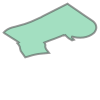

In [8]:
df.iloc[115,0]

In [9]:
a = generate_random(25, df.iloc[115,0])
b = generate_random(25, df.iloc[115,0])

In [14]:
import random
import folium

color = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(25)
]

In [15]:
m = folium.Map(location=[50.819, 4.39], zoom_start=15, tiles='stamenwatercolor')
# folium.TileLayer("stamenwatercolor").add_to(m)

for i in range(len(a)):

    
    folium.Circle(
        location=[a[i].coords.xy[1][0], a[i].coords.xy[0][0]], radius=20, color=color[i],
    ).add_to(m)
    folium.Circle(
        location=[b[i].coords.xy[1][0], b[i].coords.xy[0][0]], radius=20, color=color[i],
    ).add_to(m)
    points = [[a[i].coords.xy[1][0], a[i].coords.xy[0][0]], [b[i].coords.xy[1][0], b[i].coords.xy[0][0]]]
    folium.PolyLine(points, color=color[i], weight=2.5, opacity=1).add_to(m)

fill_style_function = lambda x: {
    "weight": 0.25,
    "color": "black",
    "fillColor": "grey",
    "fillOpacity": 0.35,
}

sim_geo = gpd.GeoSeries(df.iloc[115]['geometry'])#.simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=fill_style_function)
geo_j.add_to(mymap.map)
folium.GeoJson(gpd.GeoSeries(df["geometry"].iloc[115]).to_json()).add_to(m)

m

In [16]:
# o_path = r"../data/outputs/maps/"
# m.save(os.path.join(o_path, "random_points.html")) # to HTML

In [17]:
import geopy
import geopy.distance

# compte average distance
dist = np.array(distance(a, b))
np.mean(dist)

693.8141425118758

# Now let's do it for each neighborhood

In [ ]:
distances =  df[['NAME_FRE']]

dist = []

for i in tqdm(range(len(df))):
    
    N_EXP = 10000 #10000
    
    # Generate two lists of random points
    a = generate_random(N_EXP, df.iloc[i,0])
    b = generate_random(N_EXP, df.iloc[i,0])
    
    # Compute distances
    dist_ = np.array(distance(a, b))
    dist.append(np.mean(dist_))
    
distances["dist"] = dist
    
distances["dist"] = distances["dist"]*1.417

 30%|███████████████████████████████████████▍                                                                                             | 43/145 [07:10<15:46,  9.28s/it]

In [54]:
# distances

<AxesSubplot:xlabel='dist', ylabel='Count'>

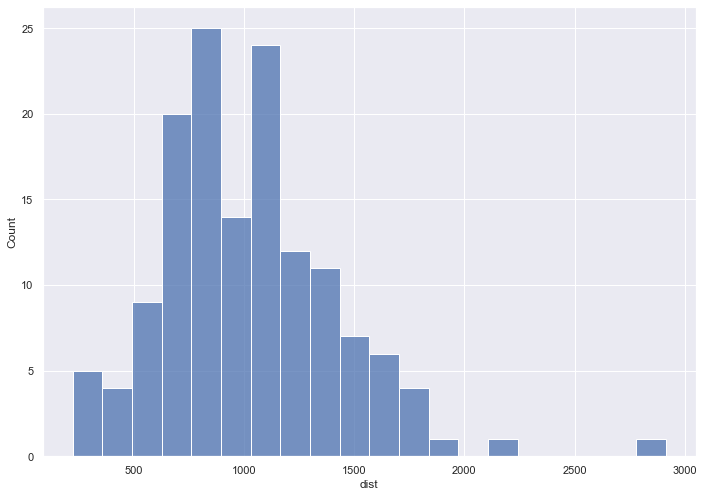

In [55]:
sns.histplot(distances[distances["dist"] < 4000]["dist"], bins=20)

In [81]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([0, 0.5, 1.5, 3.5]).reshape(-1,1)
y = [0, 0.17, 0.4, 0.59]

reg = LinearRegression().fit(x, y)
print(reg.score(x, y))
print(reg.coef_)
print(reg.intercept_)


0.9252416663054315
[0.16069565]
0.0690434782608696


In [88]:
a = np.array([0.732, 1.243, 1.522, 1.160, 1.497]).reshape(-1,1)
reg.predict(a)

array([0.1866727 , 0.26878817, 0.31362226, 0.25545043, 0.30960487])

In [84]:
a = np.linspace(0,5, 50).reshape(-1,1)
b = reg.predict(a)

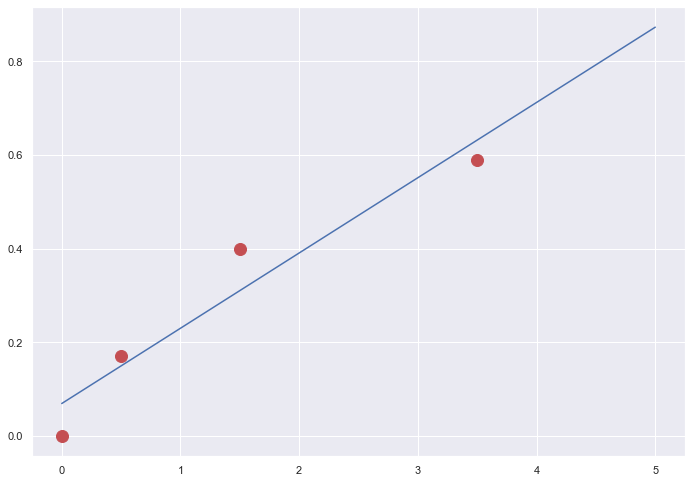

In [87]:
plt.figure()
plt.plot(x, y,'ro',markersize=12)
plt.plot(a,b)
plt.savefig('C:/Users/vic_t/OneDrive/MFE/Notes/src/linear_regression.png')

In [148]:
a = distances["dist"].to_numpy() / 1000
a = a.reshape(-1,1)
b = reg.predict(a)

distances["ratio"] = b*100

In [149]:
distances.head()

,NAME_FRE,dist,Ratio,ratio
0,CONSCIENCE,788.250123,19.571185,19.571185
1,HELMET,826.688197,20.188868,20.188868
2,VIEUX LAEKEN OUEST,638.656007,17.167272,17.167272
3,VIEUX LAEKEN EST,1072.595733,24.140495,24.140495
4,INDUSTRIE NORD,2915.174560,53.749936,53.749936


In [ ]:
distances.to_csv('../data/final_data/INDR_distances.csv', index=False)

### Now, let's plot a choropleth map to see the results

In [150]:
sectors.add_property(distances, 'dist')
sectors.add_property(distances, 'ratio')

Successfully added dist property to geodata.
Successfully added ratio property to geodata.


In [166]:
colormap_dist = cm.LinearColormap(
    ["white", "yellow", "orange", "red", "darkred", "black"],
    index=[0.0, 500.0, 1000.0, 1500.0, 2000.0, 5000.0],
    vmin=0,
    vmax=5000,
)

colormap_ratio = cm.LinearColormap(
    ["white", "beige","lightyellow", "yellow", "orange", "red", "darkred", "black"],
    index=[0, 10, 15, 20, 30, 40, 50, 100],
    vmin=0,
    vmax=100,
)
colormap_ratio

In [167]:
mymap = BrusselsMap(sectors, tile="stamenwatercolor")

attribute = "ratio"
legend = f"Choropleth Map of Brussels showing the {attribute}"
nbr_steps = 10
colormap_type = "manual"
mymap.add_choropleth_style2(
    distances[["NAME_FRE", attribute]], legend, nbr_steps, colormap_type, colormap_ratio
)

mymap.map

In [168]:
o_path = r"../data/outputs/maps/"
mymap.map.save(os.path.join(o_path, "car-ratio.html")) # to HTML

In [60]:
# # Load geodata
# r_path = r"../data/piéton"
# path = os.path.join(os.getcwd(), r_path)

# with open(path) as sectors_file:
#     pieton = json.load(sectors_file)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\vic_t\\OneDrive\\MFE\\Code\\notebooks\\../data/piéton'